# Week 5 - Non-linear regression models 

Hello again. In this notebook we will focus on non-linear regression models, specifically using **Neural Networks**!

The usual imports...

In [1]:
import numpy as np
import pandas as pd  
from matplotlib import pyplot as plt
from sklearn import linear_model
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from sklearn.model_selection import train_test_split
# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
import os
from __init__ import root_dir, data_path, src_path
os.path.abspath(root_dir)
from src.models.utils import compute_error, get_data_for_component, preprocess
%load_ext autoreload
%autoreload 2

In [2]:
X_numpy = pd.read_csv(os.path.join(data_path,'processed','data_processed.csv'),parse_dates=['datetime'])
X_numpy = X_numpy.drop(columns=['failure'])
N, D = X_numpy.shape
print("Vector of", N, "x", D)

Vector of 290642 x 41


In [3]:
life=True#flag if we want to predict lifespan or not
if life==True:
    X_numpy.dropna(axis=0, inplace=True)
components = ["comp"+str(i)+"_life" for i in range(1,5)]
X0 = get_data_for_component(X_numpy, components[0])

In [4]:

y, X, X_train_torch, y_train_torch,X_test_torch, X_test, y_test, X_train, y_train, y_std, y_mean=preprocess(X0.copy(),0.1)


Let us now try to visualize the data that we just generated. In order to keep everything in 2D, we will use the 2 axes of the plot for the values of $x_1$ and $x_2$, and use a color map to represent the corresponding values of $y$ for each point. Make sure that you understand what you are seeing :-)

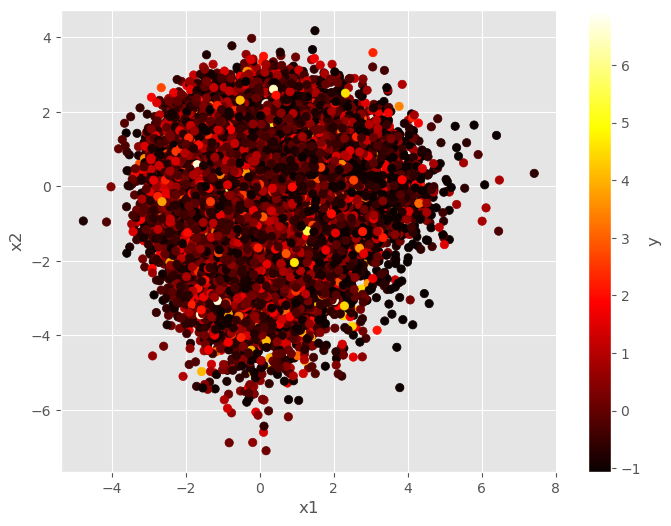

In [5]:
sc = plt.scatter(X_train_torch[:,0], X_train_torch[:,1], c=y_train_torch, cmap=plt.cm.hot)
plt.colorbar(sc, label="y")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

From the plot above, we can observe that the value of $y$ (i.e. the color) increases linearly over the $x_1$ axis (for the same value of $x_2$). However, over the $x_2$ dimension, the pattern in highly non-linear. That makes perfect sense given the way the data was generated, right?

Let us now split our generated data in a trainset and testset. We then fit a simple linear regression model on the trainset, and see how it performs on the testset. What do you think will happen? 

In [6]:
from sklearn import datasets, linear_model

regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(X_train_torch, y_train_torch)
preds_lr = regr.predict(X_test_torch)
print(regr.coef_)

[-1.3775880e-02  1.0716524e-03 -1.2307315e-03  1.6640450e-03
 -8.6010143e-04 -2.8204415e-03  2.6229597e-04  3.7947111e-04
 -2.5117554e-02 -2.6605227e-03  2.5870181e-03  1.1132961e-03
 -5.3956159e-03 -8.7619363e-04 -1.6128893e-03  5.7711871e-03
 -3.4052096e-02 -3.7997090e-03  6.0530035e-03 -2.7326681e-04
  7.5445324e-03  1.5423427e-02  3.1862695e+02  3.1900397e+02
  4.0285294e+02  3.8920804e+02]


We can already observe that the coefficient $\beta$ for the first dimension $x_1$ (which was actually linear!!) is already not being estimated very well (2.29 estimated vs 2.0 true value used to generate the data). The coefficient for the second dimension is hard to make much sense of it... It is close to zero, as if that dimension wasn't very relevant for the values of $y$ that are observed...

Let's have a look at the mean absolute error (MAE) for the predictions:

In [7]:
mae = np.mean(np.abs(y_test-preds_lr))
print("MAE:", mae)

MAE: 0.7432485469172565


A bit high given the range of the $y$ values...

Perhaps we can get a better intuition about the quality of the predictions of the linear regression model if we try to visualize them:

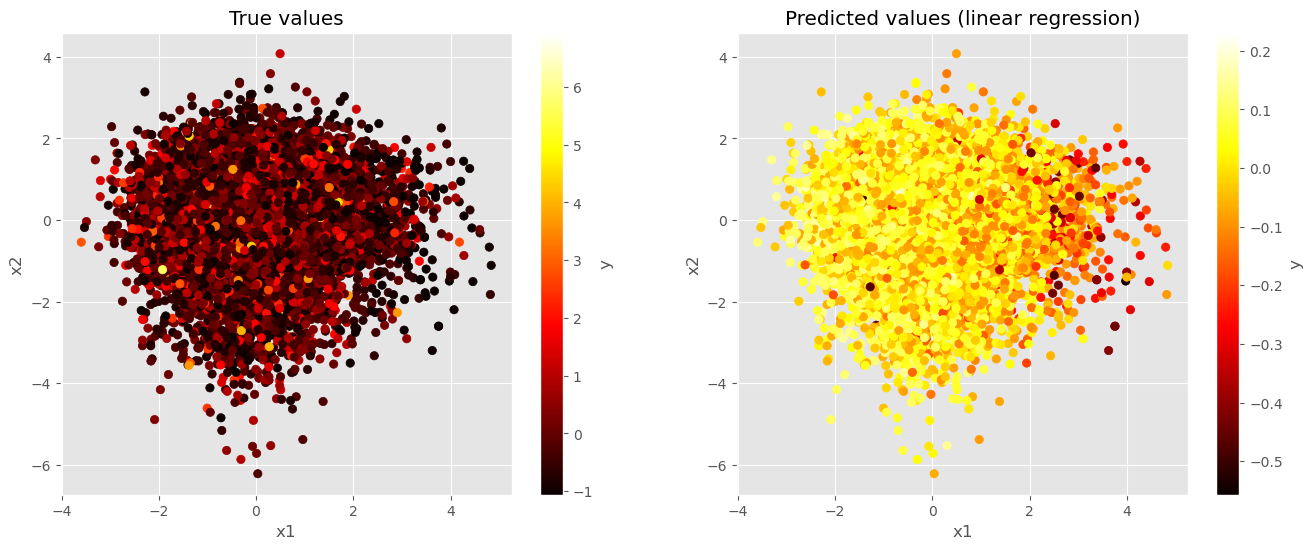

In [8]:
# Two subplots, the axes array is 1-d
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1,2)
sc = ax[0].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.hot)
ax[0].set_title('True values')
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
plt.colorbar(sc, ax=ax[0], label="y")
sc = ax[1].scatter(X_test[:,0], X_test[:,1], c=preds_lr, cmap=plt.cm.hot)
ax[1].set_title('Predicted values (linear regression)')
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
plt.colorbar(sc, ax=ax[1], label="y")
plt.show()

Comparing the true values (left) with the predicted ones (right), we can see that linear regression is making a really poor job at modelling the values of $y$ given the inputs $\{x_1,x_2\}$. It captures a bit the increasing trend over the $x_1$ dimension, but not much beyond that.

A few more plots to investigate the problem a bit further:

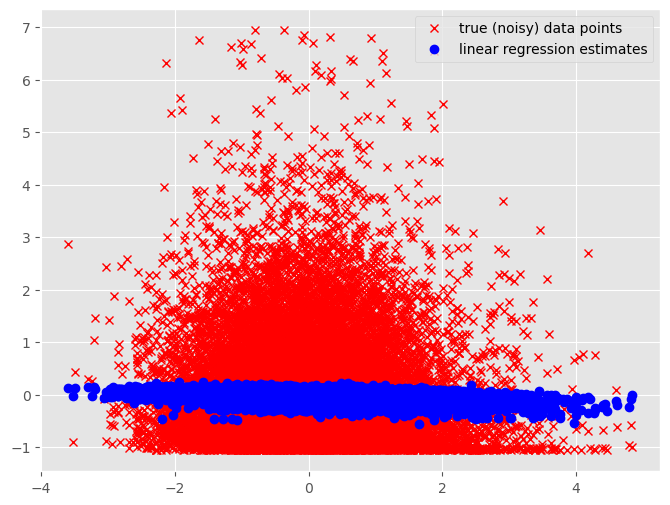

In [9]:
plt.plot(X_test[:,0], y_test, "rx")
plt.plot(X_test[:,0], preds_lr, 'bo')
plt.legend(["true (noisy) data points", "linear regression estimates"])
plt.show()

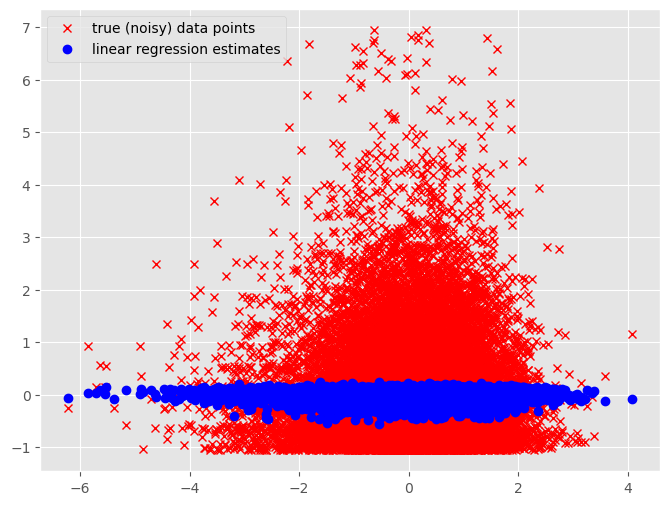

In [10]:
plt.plot(X_test[:,1], y_test, "rx")
plt.plot(X_test[:,1], preds_lr, 'bo')
plt.legend(["true (noisy) data points", "linear regression estimates"])
plt.show()

## Neural Network model in Pyro

As mentioned in the lecture's slides, we can obtain complex non-linear function of the inputs by making use of Neural Networks! The following code implements a multi-layer fully-connected NNet in Pyro. Note that, since Pyro is built on top of PyTorch, it is very well suited for building Bayesian Neural Networks and combining them with larger, more complex probabilistic graphical models. This is not the case for STAN! 

We begin by defining the neural network as a `PyroModule` instead of a PyTorch module (i.e. a class that extends ```torch.nn.Module```), as it is customary when using PyTorch for implementing deep neural networks. `PyroModule` is a subclass of `nn.Module`, which allows us to Pyro-ize an existing class (e.g. `linear_layer = PyroModule[nn.Linear](in_dim, out_dim))`) and utilize modules already created in PyTorch. Additionally, priors are placed on the weights by using `PyroSample` as illustrated below. Every neural network in PyTorch has a  `forward` function, that - implementation wise - closely resembles how you coded up Pyro models in last week's notebook.

Make sure that you understand the code above and don't hesitate to ask for clarifications! :-)

We can now perform Bayesian inference in this model (in this case using SVI) to compute the posterior distributions over the neural net weights, as we would normally do for other Pyro models:

In [11]:
# Define guide function
from src.models.models import FFNN as modelFFNN
from src.models.train_model import train_nn

model_FFNN,guide=train_nn(modelFFNN, X_train_torch, y_train_torch)



[0] ELBO: 21188534.5
[500] ELBO: 9624692.6
[1000] ELBO: 9359460.6
[1500] ELBO: 8923034.9
[2000] ELBO: 8610849.6
[2500] ELBO: 8424227.5
[3000] ELBO: 8282358.1
[3500] ELBO: 8194796.9
[4000] ELBO: 8083298.5
[4500] ELBO: 8020878.3
[5000] ELBO: 7994409.0
[5500] ELBO: 7922764.9
[6000] ELBO: 7850943.6
[6500] ELBO: 7809126.2
[7000] ELBO: 7765447.4
[7500] ELBO: 7741560.3
[8000] ELBO: 7710797.5
[8500] ELBO: 7689604.4
[9000] ELBO: 7692427.8
[9500] ELBO: 7659062.9


After convergence, we can make predictions for the test set by again leveraging the ```Predictive``` class provided by Pyro:
Let's now calculate the MAE and compare it with the linear regression model from above:

In [12]:
from pyro.infer import Predictive

# Make predictions for test set
predictive = Predictive(model_FFNN, guide=guide, num_samples=1000,return_sites=("obs", "_RETURN"))
samples = predictive(X_test_torch)

y_pred = samples["obs"].mean(axis=0).detach().numpy()
mae = np.mean(np.abs(y_test - y_pred))
print("MAE:", mae)

MAE: 0.7021383821094196


We can observe that using the Pyro model above, we were able to fit a Neural Network to our non-linear dataset, and that resulted in a much lower error. For many problems where one cares only about the prediction error this could be the end of the story. However, we will do something different here.

Assume that we are actually interested in investigating how $x_1$ affects $y$ (e.g., imagine $y$ is the price of a house and $x_1$ is the square footage), but not so much about the effect of $x_2$. You could use a NNet to model the relationship of $y$ with both $x_1$ and $x_2$, however, NNets are black-boxes that are pretty hard to interpret. So, we are at a crossroads: we can either have a simple linear model (interpretable!) or a complex neural network (black-box). But can we combine both?? :-)

In order to analyse the effect of $x_1$ of $y$, we will explore the combination of PGMs and (Bayesian) Neural Networks! To do so, we will a assume a model of the following form:

\begin{align}
y = \beta \, x_1 + \mbox{NNet}(x_2) + \epsilon
\end{align}

In other words, we use a simple linear regression for modelling the relationship with $x_1$, and a Bayesian neural network for $x_2$.

Can you modify the Pyro code of the neural network above in order to implement this variation of the model?

Once you finished implementing the model above, run inference on it using SVI:

In [19]:
from src.models.models import FFNN_interpretable as modelFFNN_interpretable
# Define guide function
model_FFNN_interpretable,guide=train_nn(modelFFNN_interpretable, X_train_torch, y_train_torch)


[0] ELBO: 29935749.1
[500] ELBO: 8174065.3
[1000] ELBO: 7770712.1
[1500] ELBO: 7495647.0
[2000] ELBO: 7303966.1
[2500] ELBO: 7173341.6
[3000] ELBO: 7096684.7
[3500] ELBO: 7023540.9
[4000] ELBO: 7027030.5
[4500] ELBO: 6946177.2
[5000] ELBO: 6922616.0
[5500] ELBO: 6908930.4
[6000] ELBO: 6897395.0
[6500] ELBO: 6871093.5
[7000] ELBO: 6860184.5
[7500] ELBO: 6842078.0
[8000] ELBO: 6829766.2
[8500] ELBO: 6814738.5
[9000] ELBO: 6824293.3
[9500] ELBO: 6803299.6


Let us now have a look at the estimated value for the coefficient $\beta$ over the input dimension $x_1$:

In [20]:
from pyro.infer import Predictive

# Get posterior samples for beta
predictive = Predictive(model_FFNN_interpretable, guide=guide, num_samples=1000,return_sites=("beta",))
samples = predictive(X_test_torch)
print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy()[0])

Unlike with the linear regression model, we managed to recover the true value of $\beta$ that was used to generate the data ($\beta=2$)!!

What can we conclude from this? It seems that modelling more accuratly the relationship between $x_2$ and $y$ with the NNet, takes away some of the "burden" from the linear part of the model, which can then focus on modelling the effect of $x_1$ better! Makes sense, right?

But that is only part of the "story". Let us now look at the predictions for the testset:

In [22]:
# Make predictions for test set
predictive = Predictive(model_FFNN_interpretable, guide=guide, num_samples=1000,return_sites=("obs", "_RETURN"))
samples = predictive(X_test_torch)
y_pred = samples["obs"].mean(axis=0).detach().numpy()
mae = np.mean(np.abs(y_test - y_pred))
print("MAE:", mae)

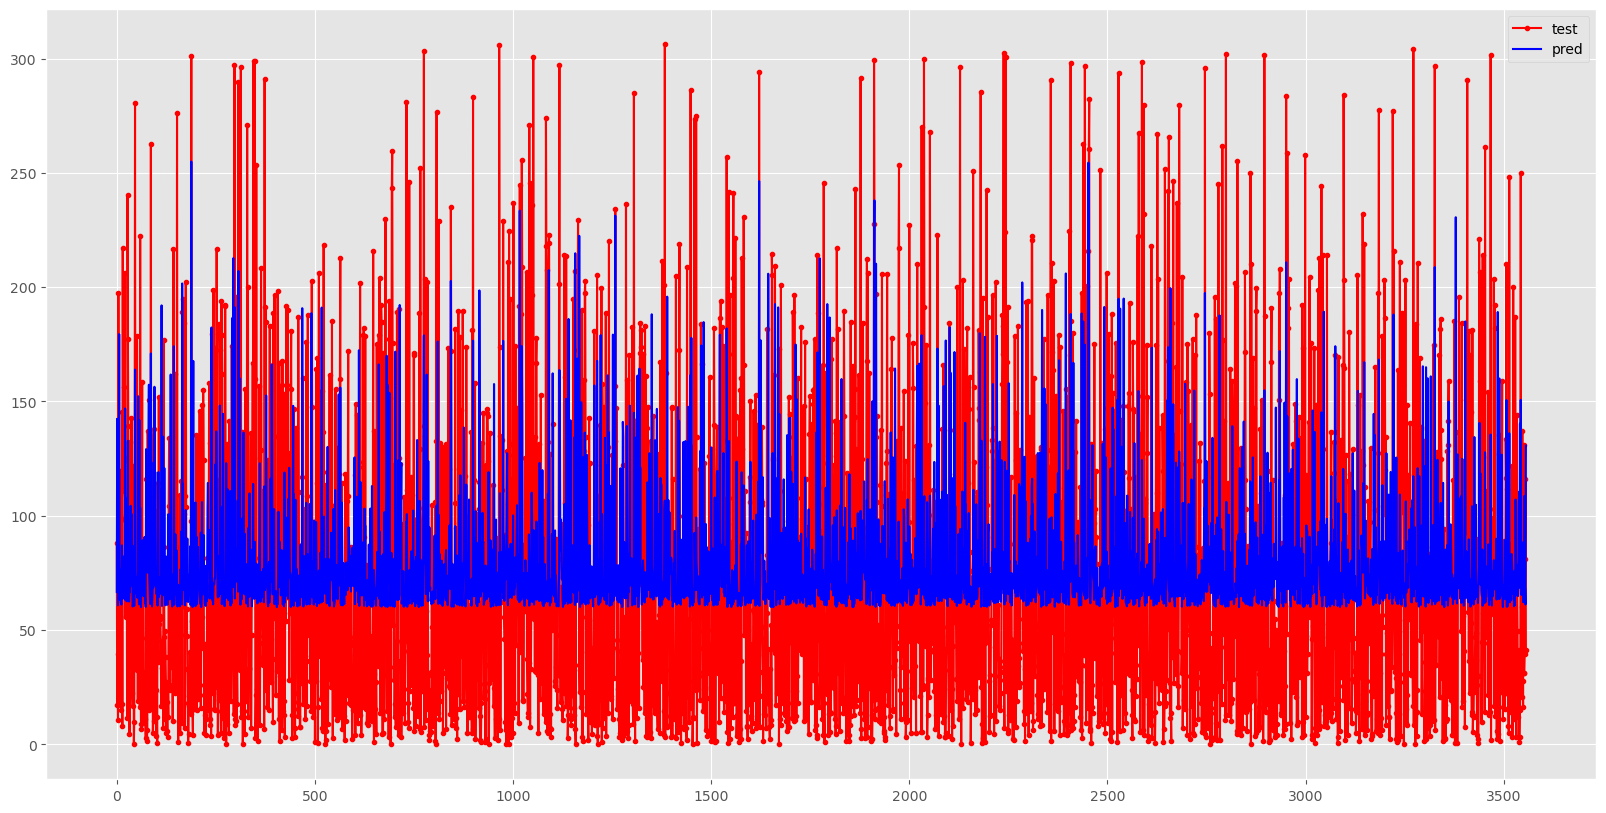

In [24]:
fig = plt.figure(figsize=(20, 10))

start = 300
end = 400
y_true = y_test * y_std + y_mean
y_pre = y_pred * y_std + y_mean

plt.plot(y_true[y_pre>60], 'r.-', label='test')
plt.plot(y_pre[y_pre>60], 'b-', label='pred')

plt.legend()

plt.show()

In [25]:
corr, mae, rae, rmse, r2, yy_true, ppreds = compute_error(y_true, y_pre, None)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

corr, mae, rae, rmse, r2, yy_true, ppreds = compute_error(y_true, y_pre, 60)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

No threshold
CorrCoef: 0.332
MAE: 27.405
RMSE: 36.367
R2: 0.097
CorrCoef: 0.085
MAE: 20.482
RMSE: 25.805
R2: 0.000


Uau! That is quite a dramatic reduction in prediction error when compared to the simple linear regression model, and we still managed to keep the interpretability over the effect of $x_1$!!

Let's see if visually we can draw a similar conclusion:

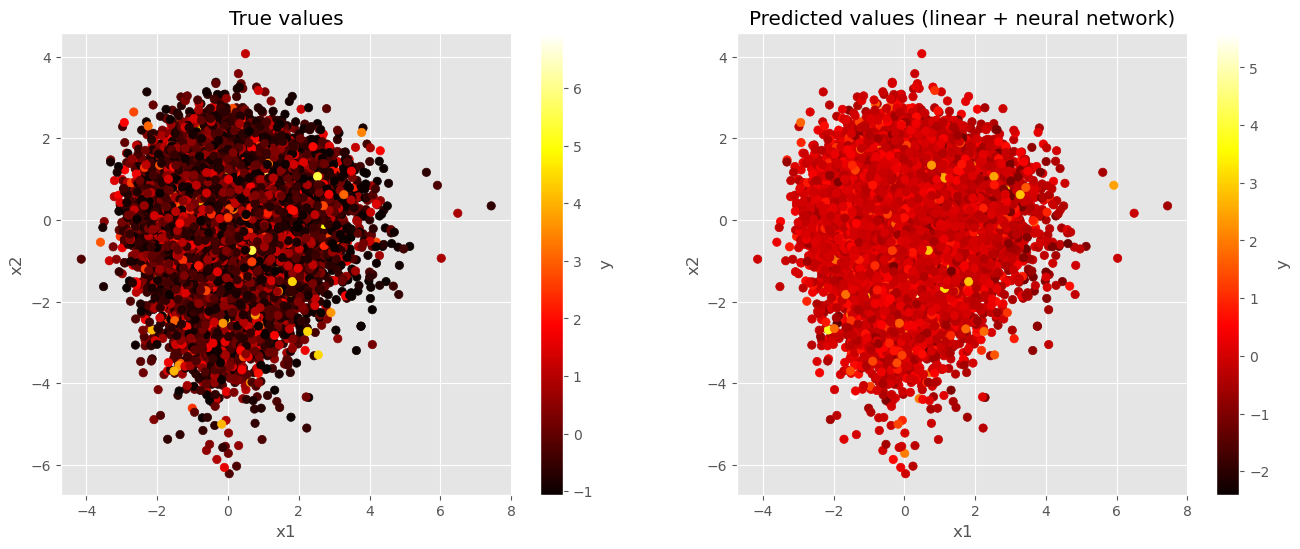

In [26]:
# Two subplots, the axes array is 1-d
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1,2)
sc = ax[0].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.hot)
ax[0].set_title('True values')
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
plt.colorbar(sc, ax=ax[0], label="y")
sc = ax[1].scatter(X_test[:,0], X_test[:,1], c=y_pred, cmap=plt.cm.hot)
ax[1].set_title('Predicted values (linear + neural network)')
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
plt.colorbar(sc, ax=ax[1], label="y")
plt.show()

We can see that the composite model (Linear PGM + NNet) predicts almost perfectly the target variable $y$ for the testset! Notice that it managed to capture both the linear trend over the $x_1$ dimension and the complex non-linear trend on the $x_2$ dimension (the one that resulted from the sine function...).

A few more visualizations to analyse the quality of the predictions of the composite model (Linear PGM + NNet) in comparison with the predictions of the linear regression model:

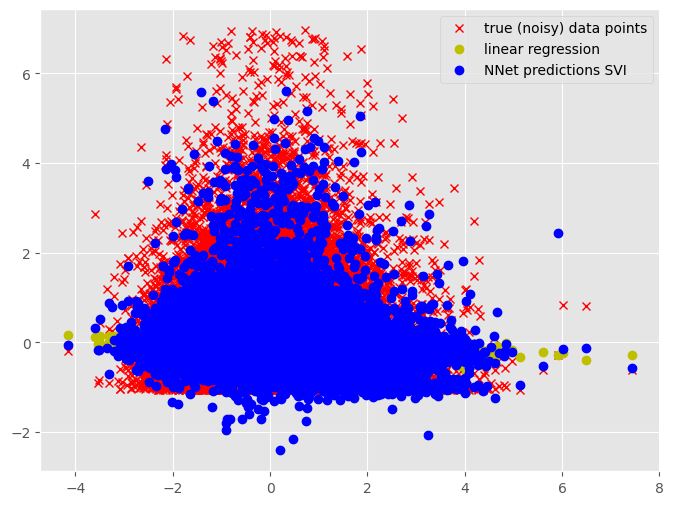

In [27]:
plt.plot(X_test[:,0], y_test, "rx")
plt.plot(X_test[:,0], preds_lr, 'yo')
plt.plot(X_test[:,0], y_pred, 'bo')
plt.legend(["true (noisy) data points", "linear regression", "NNet predictions SVI"])
plt.show()

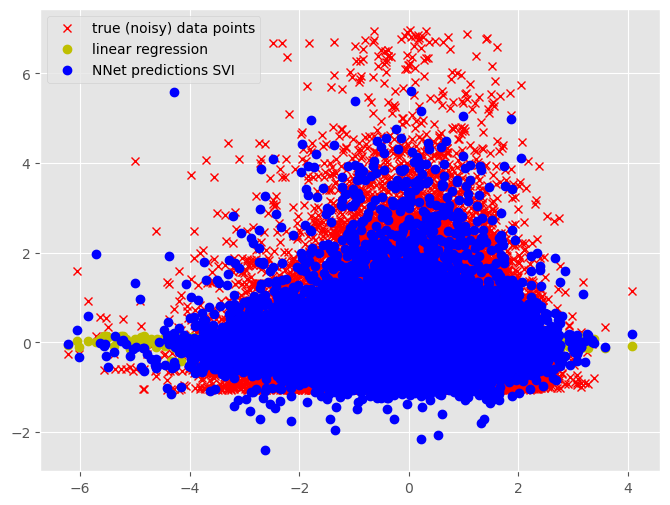

In [28]:
plt.plot(X_test[:,1], y_test, "rx")
plt.plot(X_test[:,1], preds_lr, 'yo')
plt.plot(X_test[:,1], y_pred, 'bo')
plt.legend(["true (noisy) data points", "linear regression", "NNet predictions SVI"])
plt.show()